In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../Backend/')  # so Python can find the backend module
from ai.utils import preprocess_data 

In [3]:
# Cell 2: Load your dataset
import pandas as pd

df = pd.read_csv('../data/dataset_devcamp.csv')
df['week'] = pd.to_datetime(df['week'], errors='coerce')
# Convert 'week' to separate features: year, month, and week number
df['year'] = df['week'].dt.year
df['month'] = df['week'].dt.month
df['week_num'] = df['week'].dt.isocalendar().week
df.drop(['week'], axis=1, inplace=True)

df.head()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,week_num
0,1,8091,216418,99.0375,111.8625,0,0,20,2011,1,3
1,1097,9672,223153,192.3750,236.5500,1,1,109,2011,1,3
2,1096,9672,223245,207.3375,207.3375,0,0,61,2011,1,3
3,1095,9672,222765,241.5375,241.5375,0,0,49,2011,1,3
4,1094,9672,222087,181.6875,207.3375,1,0,129,2011,1,3


In [4]:
# Check if conversion succeeded
print(df['month'].head())
print(df.dtypes)

0    1
1    1
2    1
3    1
4    1
Name: month, dtype: int32
record_ID            int64
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
year                 int32
month                int32
week_num            UInt32
dtype: object


In [5]:
# Check for nulls or basic stats
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133980 entries, 0 to 133979
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        133980 non-null  int64  
 1   store_id         133980 non-null  int64  
 2   sku_id           133980 non-null  int64  
 3   total_price      133980 non-null  float64
 4   base_price       133980 non-null  float64
 5   is_featured_sku  133980 non-null  int64  
 6   is_display_sku   133980 non-null  int64  
 7   units_sold       133980 non-null  int64  
 8   year             133980 non-null  int32  
 9   month            133980 non-null  int32  
 10  week_num         133980 non-null  UInt32 
dtypes: UInt32(1), float64(2), int32(2), int64(6)
memory usage: 9.8 MB


record_ID          0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
year               0
month              0
week_num           0
dtype: int64

In [6]:
print(df.columns)


Index(['record_ID', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'units_sold', 'year', 'month',
       'week_num'],
      dtype='object')


In [7]:
import numpy as np 
import sys
sys.path.append('../Backend/')  # so Python can find the backend module
from ai.utils import preprocess_data 
X = preprocess_data(df)
y = df['units_sold'].values

print(X.shape)




c:\Users\Pc\Desktop\HIS\HisDevcamp\notebooks\../Backend\ai\utils.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['week_start'] = pd.to_datetime(


(133980, 111)


In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint, uniform


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter distribution for RandomizedSearchCV

param_dist = {
    'n_estimators': randint(200, 1000),       # Increase range
    'max_depth': randint(5, 15),              # Allow deeper trees
    'learning_rate': uniform(0.01, 0.1),      # Narrower + lower
    'subsample': uniform(0.7, 0.3),           # Force more randomness
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5)                  # New: Regularization
}




# Initialize the XGBoost model
xgb = XGBRegressor(random_state=42)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=25,  # Number of combinations to try
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=2  # Limit the number of jobs to avoid memory overload
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE after tuning: {mae:.4f}")




Fitting 3 folds for each of 25 candidates, totalling 75 fits
MAE after tuning: 11.7650


In [9]:
model = best_model

In [10]:
test_df = pd.read_csv("../data/test_final.csv")
test_df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,190804,2013-04-09,9672,219009,225.1500,225.1500,0,0
1,190808,2013-04-09,9672,223245,233.7000,233.7000,0,0
2,190807,2013-04-09,9672,222765,254.3625,254.3625,0,0
3,190806,2013-04-09,9672,222087,214.4625,214.4625,0,0
4,190805,2013-04-09,9672,219029,341.2875,341.2875,0,0


In [11]:
import pandas as pd
import sys
sys.path.append('../Backend/ai')  # Ensure this points to the right folder

# Now import the new module
from data_preprocessing import preprocess_train_data

# Load your test set
test_df = pd.read_csv("../data/test_final.csv")


# When you preprocess the test data
X_test_final = preprocess_train_data(test_df)
X_test_final = X_test_final.fillna(0)  # This should now work
# --- STEP 2: Make predictions using your trained model ---
y_pred_test = model.predict(X_test_final)

# --- STEP 3: Create submission DataFrame ---
submission = pd.DataFrame({
    'record_ID': test_df['record_ID'],
    'units_sold': y_pred_test
})

# Optional: Round predictions if units_sold must be integer
submission['units_sold'] = submission['units_sold'].round().astype(int)

# --- STEP 4: Save to CSV ---
submission.to_csv("submission.csv", index=False)

print("✅ submission.csv is generated and ready to upload!")

c:\Users\Pc\Desktop\HIS\HisDevcamp\notebooks\../Backend/ai\data_preprocessing.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(0)


✅ submission.csv is generated and ready to upload!


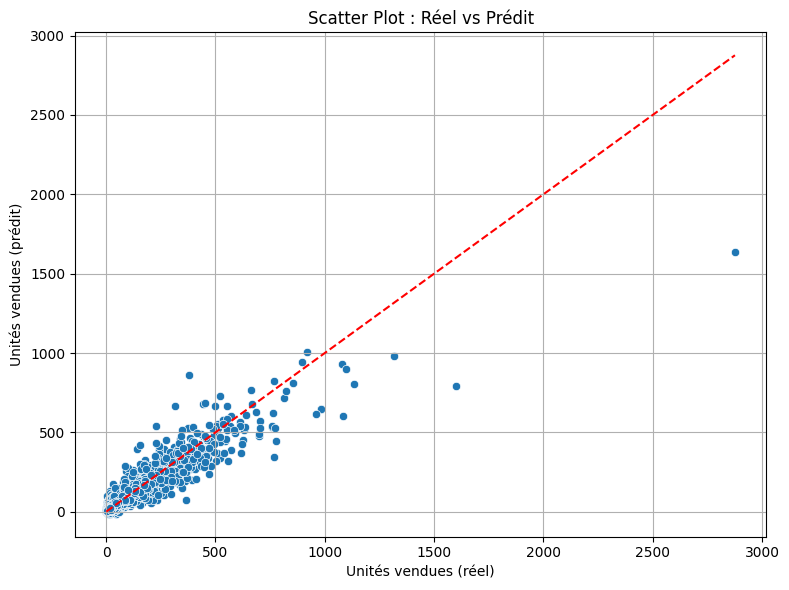

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Unités vendues (réel)")
plt.ylabel("Unités vendues (prédit)")
plt.title("Scatter Plot : Réel vs Prédit")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
print(len(y_pred_test), len(test_df))

16170 16170


In [17]:
test_df["units_sold_pred"] = y_pred_test

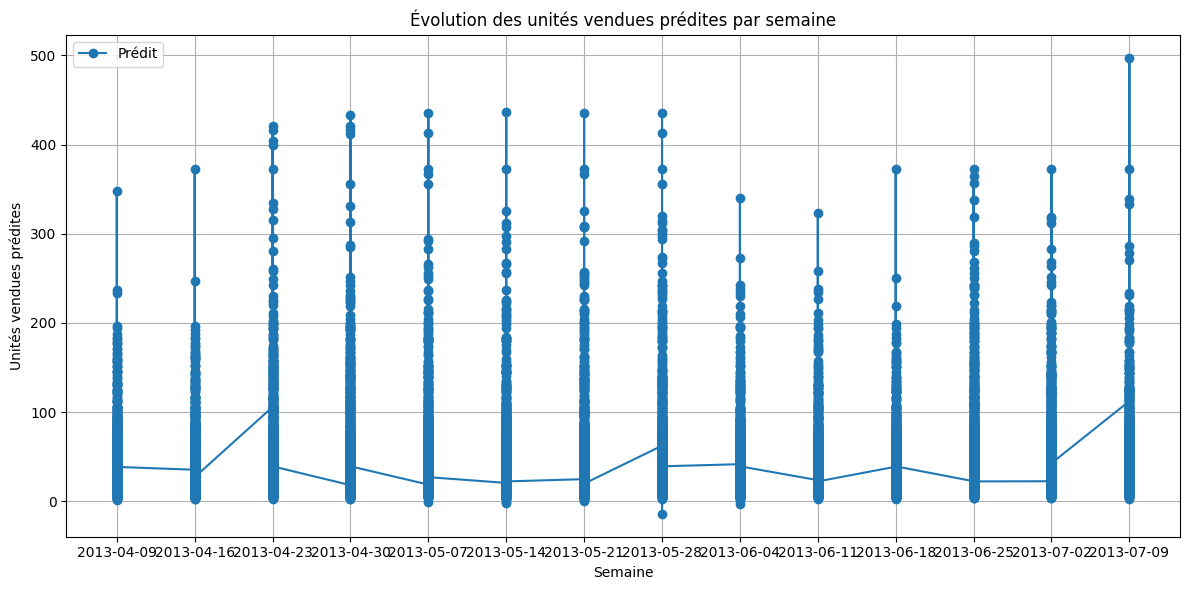

In [18]:
# On trie par semaine
test_df = test_df.sort_values("week")

plt.figure(figsize=(12, 6))
plt.plot(test_df["week"], test_df["units_sold_pred"], label="Prédit", marker='o')
plt.xlabel("Semaine")
plt.ylabel("Unités vendues prédites")
plt.title("Évolution des unités vendues prédites par semaine")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model, 'model.pkl')


['model.pkl']